In [1]:
import sys
sys.path.append('../')
from matplotlib import pyplot as plt

import pyreadr
import numpy as np
import pandas as pd

from utils.synth import *
from utils.competitors import *

In [2]:
START_TIME = 1960
INTERVENTION_TIME = 1990
STOP_TIME = 2004

In [3]:
# deal with responses
df = pd.read_stata('repgermany.dta')
response_df = df.pivot(index='year', columns='country', values='gdp')
germany_response_df = response_df[['West Germany']]
non_germany_response_df = response_df.drop(columns='West Germany')
Z1 = germany_response_df[(germany_response_df.index < INTERVENTION_TIME) & (germany_response_df.index >= START_TIME)]
Y1 = germany_response_df[(germany_response_df.index >= INTERVENTION_TIME) & (germany_response_df.index < STOP_TIME)]
Z0 = non_germany_response_df[(non_germany_response_df.index < INTERVENTION_TIME) & (non_germany_response_df.index >= START_TIME)]
Y0 = non_germany_response_df[(non_germany_response_df.index >= INTERVENTION_TIME) & (non_germany_response_df.index < STOP_TIME)]

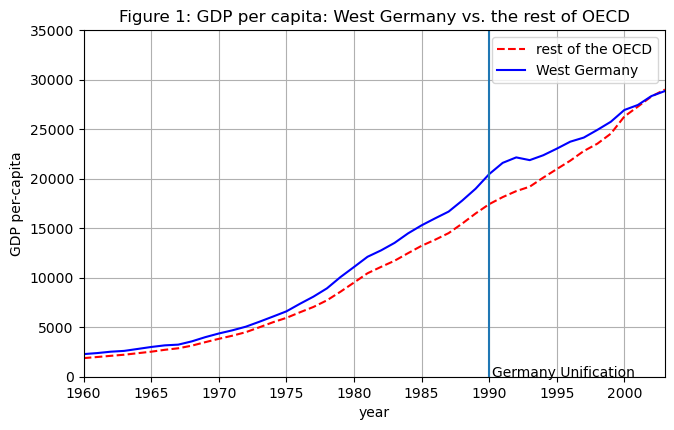

In [4]:
mean_outcomes = np.vstack([Z0, Y0]).mean(axis=1)
GER_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5))
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the OECD");
plt.plot(range(START_TIME,STOP_TIME),GER_outcomes, 'b-', label="West Germany");

plt.ylabel('GDP per-capita')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: GDP per capita: West Germany vs. the rest of OECD")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Germany Unification')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 35000])
plt.grid()
plt.show()
# fig.savefig("name", dpi=300)

In [5]:
T0 = INTERVENTION_TIME - START_TIME
T1 = STOP_TIME - INTERVENTION_TIME
J = Y0.shape[1]
Y1_pre = Z1.to_numpy().astype('float64')
Y0_pre = Z0.to_numpy().astype('float64')
Y1_post = Y1.to_numpy().astype('float64')
Y0_post = Y0.to_numpy().astype('float64')

In [6]:
## reduce to least square problem
# Y0_pre_plus = np.hstack([np.ones((Y1_pre.shape[0], 1)), Y0_pre])
# inv = np.linalg.pinv(Y0_pre_plus.T @ Y0_pre_plus)
# W_gen = inv @ Y0_pre_plus.T @ Y1_pre
# print(np.sum(np.abs(W_gen[1:])))
# print((Y1_pre - Y0_pre_plus @ W_gen) @ (Y1_pre - Y0_pre_plus @ W_gen))

In [7]:
## looking for the best lambda and K's.
## looking for the best alpha and K's.
sol = 'GUROBI'
alpha_sum_l2, K_sum_l2 = loo_selector_parallel(Y0_post/10000, method='s-const-l2', solver=sol)
alpha_sum_inf, K_sum_inf = loo_selector_parallel(Y0_post, method='s-const-inf', solver=sol)
alpha_inf, K_inf = loo_selector_parallel(Y0_post, method='inf', solver=sol)
alpha_l1, K_l1 = loo_selector_parallel(Y0_post, method='l1', solver=sol)
alpha_l2, K_l2 = loo_selector_parallel(Y0_post, method='l2', solver=sol)
alpha_l1_inf, K_l1_inf = loo_selector_parallel(Y0_post, method='l1-inf', solver=sol)
alpha_l1_l2, K_l1_l2 = loo_selector_parallel(Y0_post, method='l1-l2', solver=sol)

/home/youhui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/youhui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/youhui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/youhui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/youhui/.local/lib/python3.10/site-pack

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [8]:
w_sum_inf = our(Y1_pre, Y0_pre, 1, 2, 's-const-inf')
w_inf = our(Y1_pre, Y0_pre, alpha_inf, K_inf, 'inf')
w_l1 = our(Y1_pre, Y0_pre, alpha_l1, K_l1, 'l1')
w_l2 = our(Y1_pre, Y0_pre, alpha_l2, K_l2, 'l2')
w_l1_inf = our(Y1_pre, Y0_pre, alpha_l1_inf, K_l1_inf, 'l1-inf')
w_sum_l2 = our(Y1_pre, Y0_pre, alpha_sum_l2, K_sum_l2, 's-const-l2')
w_l1_l2 = our(Y1_pre, Y0_pre, alpha_l1_l2, K_l1_l2, 'l1-l2')

## competitors
w_did = np.nan
w_sc = sc(Y1_pre, Y0_pre)

SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
Y0_post_plus = np.hstack([np.ones((Y1_post.shape[0], 1)), Y0_post])

tau_sc = Y1_post - Y0_post @ w_sc
tau_inf = Y1_post - Y0_post_plus @ w_inf
tau_sum_inf = Y1_post - Y0_post_plus @ w_sum_inf
tau_l1 = Y1_post - Y0_post_plus @ w_l1
tau_l2 = Y1_post - Y0_post_plus @ w_l2
tau_l1_inf = Y1_post - Y0_post_plus @ w_l1_inf
tau_sum_l2 = Y1_post - Y0_post_plus @ w_sum_l2
tau_l1_l2 = Y1_post - Y0_post_plus @ w_l1_l2

In [ ]:
W = np.array([w_sc, w_sum_l2[1:], w_sum_inf[1:], w_l1[1:], w_l2[1:], w_inf[1:], w_l1_l2[1:], w_l1_inf[1:]])
mu = np.array([0, w_sum_l2[0], w_sum_inf[0], w_l1[0], w_l2[0], w_inf[0], w_l1_l2[0], w_l1_inf[0]])
Tau = np.array([tau_sc, tau_sum_l2, tau_sum_inf, tau_l1, tau_l2, tau_inf, tau_l1_l2, tau_l1_inf])

In [ ]:
methods = ['Synthetic Control',
          's-constr + L2', 's-constr + infty', 
          'L1', 'L2', 'L-inf', 'L1 + L2', 'L1 + L-inf'] 

SC_outcomes = np.vstack([Z0, Y0]).dot(W.T) + mu.reshape(1, len(methods))
WG_outcomes = np.vstack([Z1, Y1]).flatten()


colors = [
    '#E69F00',  # Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Bluish Green
    '#F0E442',  # Yellow
    '#0072B2',  # Blue
    '#D55E00',  # Vermilion
    '#CC79A7',  # Reddish Purple
    '#999999'
]
line_styles = [
    '-',    # Solid
    '--',   # Dashed
    '-.',   # Dash-dot
]

fig = plt.figure(figsize=(7.5,4.5)) 
plt.plot(range(START_TIME,STOP_TIME),WG_outcomes, 'b-', label="West Germany");
for i in range(len(methods)):
    plt.plot(range(START_TIME,STOP_TIME), SC_outcomes[:, i], color=colors[i], linestyle=line_styles[i%3], label=methods[i])
# plt.plot(range(START_TIME,STOP_TIME),SC_outcomes);

plt.ylabel('GDP per-capita')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.title("Figure 2: GDP per-capita: West Germany vs. synthetic West Germany")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Re-Unification')
plt.xlim([START_TIME, STOP_TIME-1])
# plt.ylim([0, 140])
plt.grid()
plt.show()
fig.savefig('west_germany.png')

In [ ]:
# alphas = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, alpha_l1_l2, alpha_l1_inf])
# Ks = np.array([np.nan, K_sum_l2, K_sum_inf, K_l1, K_l2, K_inf, K_l1_l2, K_l1_inf])
# df = pd.DataFrame(np.hstack([SC_outcomes[T0:,:].T, alphas.reshape(7, 1), Ks.reshape(7, 1)]), 
#                   index=methods, columns=np.append(np.arange(INTERVENTION_TIME, STOP_TIME), ['lambda', 'K']))
df = pd.DataFrame(SC_outcomes[T0:,:].T, 
                  index=methods, columns=np.arange(INTERVENTION_TIME, STOP_TIME))
pd.set_option('display.width', 120)  # Set this as per your screen width
pd.set_option('display.max_columns', None)  # None means unlimited
# Display the DataFrame
styled_df = df.style.format('{:,.2f}') \
                    .set_properties(**{'border': '1px solid black', 'text-align': 'right'}) \
                    .set_table_styles([{'selector': 'th', 
                                        'props': [('background-color', 'lightgray'), 
                                                  ('border', '2px solid black'),
                                                  ('text-align', 'center')]}],
                                      overwrite=False)

styled_df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have a DataFrame `df` with the states as the index
# and each column representing a different method's weights

# Example DataFrame creation
states = non_germany_response_df.columns.values
data = W.T
df = pd.DataFrame(data, index=states, columns=methods)

# Set global font sizes using rcParams
plt.rcParams.update({'font.size': 12})  # Adjust this value as needed

# Create subplots
ncols = len(methods)//2
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 18), sharey=True)

# Set a title for the entire figure with larger font
fig.suptitle('California: Weights', fontsize=20)

# Loop over the methods and plot each as a horizontal bar plot
for idx, method in enumerate(methods):
    i, j = idx // ncols, idx % ncols
    axes[i,j].set_xlabel('Weights', fontsize=16)
    axes[i,j].set_xlim([-1, 1])  # Set x-axis limits
    axes[i,j].grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    axes[i,j].barh(df.index, df[method], color=colors[idx], label=method)
    axes[i,j].legend(fontsize=14)

# Set the y-axis labels only on the first subplot with larger font
axes[0,0].set_ylabel('States', fontsize=16)
axes[1,0].set_ylabel('States', fontsize=16)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make space for the suptitle
plt.show()
fig.savefig('germany_weights.png')